# 1. Project Overview
Zone Classification for Bilbao Housing

## 2. Imports

In [55]:
# Core imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Model imports (baseline + advanced)
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Preprocessing & evaluation imports
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import optuna

# Interpretability imports
import shap
from alibi.explainers import ALE, plot_ale

## 3. Data Loading & Basic Preprocessing

In [56]:
data = pd.read_csv('../data/cleaned/data_final.csv')

# Drop non-predictive free-text columns
data = data.drop(columns=["url", "description"])

# Cast object/text columns to categorical dtype for algorithms that support native categorical handling
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].astype('category')

# Optional inspection
# data.info()
# data.head()

## 4. Problem Definition: Zone Classification
We aim to predict the broader `zone` category for each property listing. The more granular `neighborhood` column is removed to focus on generalized zone placement.

### 5. Feature / Target Separation

In [57]:
# Remove neighborhood to classify broader zone
data_zone = data.drop(columns=["neighborhood"])

# Split predictors and target
X_zone = data_zone.drop(columns=["zone"])
y_zone = data_zone["zone"]

# Optional sanity checks
# print(y_zone.head())
# X_zone.head()

### 6. Evaluation Setup: Metrics & Model

In [ ]:
# Multi-metric scoring for imbalance & multi-class quality
SCORING = {
    'accuracy': 'accuracy',
    'recall_weighted': 'recall_weighted',
    'precision_weighted': 'precision_weighted',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',        # Critical: reveals performance on minority classes
    'matthews': 'matthews_corrcoef',
    'balanced_accuracy': 'balanced_accuracy'
}

# Diverse baseline and advanced models
MODELS = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Random Forest (tuned)': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial'),
    'Naive Bayes': GaussianNB(),
    # 'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),  # commented due to runtime cost, they will be executed later with GPU
    # 'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True), # commented due to runtime cost, they will be executed later with GPU
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False),
    'Neural Network (MLP)': make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
}

# Stratified CV preserves class distribution
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Train/Test Split
We do the `train_test_split` at the beginning to avoid data leakage. We will use `X_train` and `y_train` for cross validation and Optuna; the final performance will be measured using `X_test` and `y_test`.

In [59]:
# Train/Test Split - avoid data leakage
from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

# Assume that `X_zone` and `y_zone` are already built in previous cells
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_zone, y_zone,
    test_size=0.2,
    stratify=y_zone,
    random_state=RANDOM_STATE
)

### 7. Model Evaluation Helper

In [60]:
def evaluate_models(X, y, cv_strategy=cv_strategy, scoring=SCORING, models=MODELS):
    """Cross-validate a dictionary of models, returning mean/std for each metric."""
    results = {}
    for name, model in models.items():
        print(f"\n{name}:")
        scores = cross_validate(model, X, y, cv=cv_strategy, scoring=scoring, return_train_score=False, n_jobs=-1)
        results[name] = {}
        for metric_name, metric_scores in scores.items():
            if metric_name.startswith('test_'):
                metric = metric_name.replace('test_', '')
                results[name][metric] = (metric_scores.mean(), metric_scores.std())
                print(f"  {metric}: {metric_scores.mean():.4f} (+/- {metric_scores.std():.4f})")
    return results

### 8. Strategy 1: One-Hot Encode Selected Categoricals

In [61]:
# Strategy 1
print("="*80)
print("Strategy 1: Use all variables; one-hot encode selected categorical features")
print("="*80)

cat_cols1 = ["exterior", "condition", "agency", "consumption_label", "emissions_label"]

X_zone_encoded_1 = pd.get_dummies(X_train_raw, columns=cat_cols1)
# Remove special characters from column names to avoid issues in certain models
X_zone_encoded_1.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_zone_encoded_1.columns]
y_zone_encoded_1 = LabelEncoder().fit_transform(y_train_raw)

print(f"\nSamples: {len(X_zone_encoded_1)}")
print(f"Features: {X_zone_encoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_encoded_1)}")

result1 = evaluate_models(X_zone_encoded_1, y_zone_encoded_1, models=MODELS, cv_strategy=cv_strategy)

print("\n" + "="*80)

Strategy 1: Use all variables; one-hot encode selected categorical features

Samples: 983
Features: 324
Class distribution: [189 102  61  49  72 125 109  26 134  26  90]

Random Forest:
  accuracy: 0.5941 (+/- 0.0111)
  recall_weighted: 0.5941 (+/- 0.0111)
  precision_weighted: 0.6260 (+/- 0.0213)
  f1_weighted: 0.5797 (+/- 0.0118)
  f1_macro: 0.5569 (+/- 0.0323)
  matthews: 0.5398 (+/- 0.0130)
  balanced_accuracy: 0.5334 (+/- 0.0280)

Random Forest (tuned):
  accuracy: 0.5941 (+/- 0.0111)
  recall_weighted: 0.5941 (+/- 0.0111)
  precision_weighted: 0.6260 (+/- 0.0213)
  f1_weighted: 0.5797 (+/- 0.0118)
  f1_macro: 0.5569 (+/- 0.0323)
  matthews: 0.5398 (+/- 0.0130)
  balanced_accuracy: 0.5334 (+/- 0.0280)

Random Forest (tuned):
  accuracy: 0.5321 (+/- 0.0213)
  recall_weighted: 0.5321 (+/- 0.0213)
  precision_weighted: 0.5999 (+/- 0.0626)
  f1_weighted: 0.5012 (+/- 0.0219)
  f1_macro: 0.4516 (+/- 0.0424)
  matthews: 0.4697 (+/- 0.0254)
  balanced_accuracy: 0.4320 (+/- 0.0332)

Logist

### 9. Strategy 1.1: Native Categorical Handling

In [62]:
# Models that natively handle categorical features
MODELS_NATIVE = {
    'XGBoost': XGBClassifier(
        n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1,
        tree_method="hist", enable_categorical=True, use_label_encoder=False, eval_metric='mlogloss'
    ),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False,
        cat_features=cat_cols1),
}

print("="*80)
print("Strategy 1.1: Use all variables with native categorical support (no one-hot)")
print("="*80)

X_zone_unencoded_1 = X_train_raw.copy()
# Clean column names (avoid special chars)
X_zone_unencoded_1.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_zone_unencoded_1.columns]
y_zone_unencoded_1 = LabelEncoder().fit_transform(y_train_raw)

print(f"\nSamples: {len(X_zone_unencoded_1)}")
print(f"Features: {X_zone_unencoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_unencoded_1)}")

result11 = evaluate_models(X_zone_unencoded_1, y_zone_unencoded_1, models=MODELS_NATIVE, scoring=SCORING)
print("\n" + "="*80)

Strategy 1.1: Use all variables with native categorical support (no one-hot)

Samples: 983
Features: 17
Class distribution: [189 102  61  49  72 125 109  26 134  26  90]

XGBoost:
  accuracy: 0.5972 (+/- 0.0162)
  recall_weighted: 0.5972 (+/- 0.0162)
  precision_weighted: 0.6023 (+/- 0.0149)
  f1_weighted: 0.5908 (+/- 0.0179)
  f1_macro: 0.5845 (+/- 0.0267)
  matthews: 0.5439 (+/- 0.0172)
  balanced_accuracy: 0.5793 (+/- 0.0272)

LightGBM:
  accuracy: 0.5972 (+/- 0.0162)
  recall_weighted: 0.5972 (+/- 0.0162)
  precision_weighted: 0.6023 (+/- 0.0149)
  f1_weighted: 0.5908 (+/- 0.0179)
  f1_macro: 0.5845 (+/- 0.0267)
  matthews: 0.5439 (+/- 0.0172)
  balanced_accuracy: 0.5793 (+/- 0.0272)

LightGBM:
  accuracy: 0.6297 (+/- 0.0216)
  recall_weighted: 0.6297 (+/- 0.0216)
  precision_weighted: 0.6384 (+/- 0.0263)
  f1_weighted: 0.6212 (+/- 0.0222)
  f1_macro: 0.5996 (+/- 0.0137)
  matthews: 0.5805 (+/- 0.0248)
  balanced_accuracy: 0.5914 (+/- 0.0155)

CatBoost:
  accuracy: 0.6297 (+/- 0.02

### 10. Strategy 1.2: SVM with Reduced Dimensionality

In [ ]:
# THERE IS NO WAY TO RUN THIS, IT LASTS FOREVER, SO IT IS COMMENTED
# IN THE NEXT CELL, I WILL USE GPU TO RUN IT FASTER
'''
# SVM models (runtime heavy; dimensionality reduced by dropping high-cardinality/less informative categorical columns)
MODELS_SVM = {
    'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True)
}

print("="*80)
print("Strategy 1.2: SVM with reduced categorical set (agency & energy labels removed)")
print("="*80)

X_zone_encoded_12 = X_train_raw.copy()
X_zone_encoded_12.drop(columns=["agency", "consumption_label", "emissions_label"], inplace=True)

cat_cols12 = ["exterior", "condition"]
X_zone_encoded_12 = pd.get_dummies(X_zone_encoded_12, columns=cat_cols12)
X_zone_encoded_12.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_zone_encoded_12.columns]

y_zone_encoded_12 = LabelEncoder().fit_transform(y_train_raw)
print(f"\nSamples: {len(X_zone_encoded_12)}")
print(f"Features: {X_zone_encoded_12.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_encoded_12)}")

result12 = evaluate_models(X_zone_encoded_12, y_zone_encoded_12, models=MODELS_SVM, scoring=SCORING)

print("\n" + "="*80)
'''

'\n# SVM models (runtime heavy; dimensionality reduced by dropping high-cardinality/less informative categorical columns)\nMODELS_SVM = {\n    \'SVM (Linear)\': SVC(kernel=\'linear\', random_state=42, probability=True),\n    \'SVM (RBF)\': SVC(kernel=\'rbf\', random_state=42, probability=True)\n}\n\nprint("="*80)\nprint("Strategy 1.2: SVM with reduced categorical set (agency & energy labels removed)")\nprint("="*80)\n\nX_zone_encoded_12 = X_train_raw.copy()\nX_zone_encoded_12.drop(columns=["agency", "consumption_label", "emissions_label"], inplace=True)\n\ncat_cols12 = ["exterior", "condition"]\nX_zone_encoded_12 = pd.get_dummies(X_zone_encoded_12, columns=cat_cols12)\nX_zone_encoded_12.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_zone_encoded_12.columns]\n\ny_zone_encoded_12 = LabelEncoder().fit_transform(y_train_raw)\nprint(f"\nSamples: {len(X_zone_encoded_12)}")\nprint(f"Features: {X_zone_encoded_12.shape[1]}")\nprint(f"Class distribution: {np.bincount(y_

In [ ]:
# SVM WITH GPU 
# AS TO RUN IT WITH GPU I HAD TO EXECUTE IT IN COLAB (I DON'T HAVE GPU IN MY COMPUTER), AND THE REST OF THE CODE
# IS EXECUTED IN VSCODE LOCALLY, THE RESULTS ARE COPIED FROM COLAB TO HERE. I HAVE FOLLOWED THE APPROACH IN THE BONUS
# SECTION OF ALUD (CHANGE THE RUNTIME TO GPU, AND USE CUML)

# I LEAVE THE CODE THAT I USED IN COLAB TO RUN IT WITH GPU BELOW, BUT IT IS COMMENTED AS IT CANNOT BE RUN LOCALLY
'''
import cuml
from cuml.svm import SVC as CuSVC
from cuml.svm import LinearSVC as CuLinearSVC
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler # Importamos StandardScaler
import pandas as pd
import numpy as np

cuml.set_global_output_type('numpy')

SCORING = {
    'accuracy': 'accuracy',
    'recall_weighted': 'recall_weighted',
    'precision_weighted': 'precision_weighted',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',
    'matthews': 'matthews_corrcoef',
    'balanced_accuracy': 'balanced_accuracy'
}

print("="*80)
print("Extra strategy 1.2 (GPU): SVM Escalar + Output Numpy")
print("="*80)

X_zone_encoded_12 = X_train_raw.copy()
X_zone_encoded_12.drop(columns=["agency", "consumption_label", "emissions_label"], inplace=True)

cat_cols12 = ["exterior", "condition"]
X_zone_encoded_12 = pd.get_dummies(X_zone_encoded_12, columns=cat_cols12)
X_zone_encoded_12.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_zone_encoded_12.columns]

scaler = StandardScaler()
X_zone_encoded_12 = scaler.fit_transform(X_zone_encoded_12)

X_zone_encoded_12 = X_zone_encoded_12.astype('float32')

y_zone_encoded_12 = LabelEncoder().fit_transform(y_train_raw)

print(f"\nSamples: {len(X_zone_encoded_12)}")
print(f"Features: {X_zone_encoded_12.shape[1]}")

MODELS_SVM_GPU = {
    'SVM (Linear) - GPU': CuLinearSVC(C=1.0, probability=False, max_iter=2000), 
    'SVM (RBF) - GPU': CuSVC(kernel='rbf', C=1.0, probability=False)
}

# --- Evaluation ---
print("\nTraining on GPU...")

results_gpu = {}
for name, model in MODELS_SVM_GPU.items():
    print(f"\n{name}:")
    try:
        scores = cross_validate(model, X_zone_encoded_12, y_zone_encoded_12, 
                                cv=cv_strategy, scoring=SCORING, 
                                return_train_score=False, n_jobs=1) 
        
        results_gpu[name] = {}
        for metric_name, metric_scores in scores.items():
            if metric_name.startswith('test_'):
                metric = metric_name.replace('test_', '')
                results_gpu[name][metric] = (metric_scores.mean(), metric_scores.std())
                print(f"  {metric}: {metric_scores.mean():.4f} (+/- {metric_scores.std():.4f})")
    except Exception as e:
        print(f"Error training {name}: {str(e)}")

print("\n" + "="*80)
'''


# RESULTS
'''
================================================================================
Strategy 1.2 (GPU): SVM Escalar + Output Numpy
================================================================================

Samples: 983
Features: 17

Training on GPU...

SVM (Linear) - GPU:
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  accuracy: 0.3897 (+/- 0.0190)
  recall_weighted: 0.3897 (+/- 0.0190)
  precision_weighted: 0.3503 (+/- 0.0222)
  f1_weighted: 0.3303 (+/- 0.0187)
  f1_macro: 0.2545 (+/- 0.0166)
  matthews: 0.3013 (+/- 0.0213)
  balanced_accuracy: 0.2816 (+/- 0.0156)

SVM (RBF) - GPU:
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
  accuracy: 0.4263 (+/- 0.0288)
  recall_weighted: 0.4263 (+/- 0.0288)
  precision_weighted: 0.4567 (+/- 0.0645)
  f1_weighted: 0.3873 (+/- 0.0306)
  f1_macro: 0.3011 (+/- 0.0310)
  matthews: 0.3444 (+/- 0.0360)
  balanced_accuracy: 0.3077 (+/- 0.0264)

================================================================================
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
'''

### 11. Strategy 1.3: Class Weight Balancing

In [64]:
# Test multiple models with class_weight adjustments where supported
MODELS_BALANCED = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Random Forest (tuned)': RandomForestClassifier(n_estimators=300, max_depth=15, min_samples_split=5, random_state=42, n_jobs=-1, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial', class_weight='balanced'),
    'Naive Bayes': GaussianNB(),
    # 'SVM (Linear)': SVC(kernel='linear', random_state=42, probability=True),
    # 'SVM (RBF)': SVC(kernel='rbf', random_state=42, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(max_iter=100, random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1, class_weight='balanced'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    'CatBoost': CatBoostClassifier(iterations=100, random_state=42, verbose=0, allow_writing_files=False),
    'Neural Network (MLP)': make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42))
}

print("="*80)
print("Strategy 1.3: Evaluate models with class_weight='balanced'")
print("="*80)

print(f"\nSamples: {len(X_zone_encoded_1)}")
print(f"Features: {X_zone_encoded_1.shape[1]}")
print(f"Class distribution: {np.bincount(y_zone_encoded_1)}")

result13 = evaluate_models(X_zone_encoded_1, y_zone_encoded_1, models=MODELS_BALANCED, cv_strategy=cv_strategy)

print("\n" + "="*80)

Strategy 1.3: Evaluate models with class_weight='balanced'

Samples: 983
Features: 324
Class distribution: [189 102  61  49  72 125 109  26 134  26  90]

Random Forest:
  accuracy: 0.5697 (+/- 0.0244)
  recall_weighted: 0.5697 (+/- 0.0244)
  precision_weighted: 0.5968 (+/- 0.0337)
  f1_weighted: 0.5567 (+/- 0.0268)
  f1_macro: 0.5475 (+/- 0.0379)
  matthews: 0.5109 (+/- 0.0284)
  balanced_accuracy: 0.5212 (+/- 0.0332)

Random Forest (tuned):
  accuracy: 0.5697 (+/- 0.0244)
  recall_weighted: 0.5697 (+/- 0.0244)
  precision_weighted: 0.5968 (+/- 0.0337)
  f1_weighted: 0.5567 (+/- 0.0268)
  f1_macro: 0.5475 (+/- 0.0379)
  matthews: 0.5109 (+/- 0.0284)
  balanced_accuracy: 0.5212 (+/- 0.0332)

Random Forest (tuned):
  accuracy: 0.5535 (+/- 0.0285)
  recall_weighted: 0.5535 (+/- 0.0285)
  precision_weighted: 0.5784 (+/- 0.0259)
  f1_weighted: 0.5490 (+/- 0.0265)
  f1_macro: 0.5388 (+/- 0.0389)
  matthews: 0.4959 (+/- 0.0312)
  balanced_accuracy: 0.5375 (+/- 0.0413)

Logistic Regression:
  

### 12. Hyperparameter Optimization with Optuna

In [65]:
def objective(trial):
    # Optuna search space tuned for small, imbalanced dataset
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'class_weight': 'balanced',
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 60),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': 1
    }
    model = LGBMClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_zone_unencoded_1, y_zone_unencoded_1, cv=cv, scoring='f1_macro', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize', study_name="LGBM_Optimization")
print("Running Optuna optimization (50 trials)...")
study.optimize(objective, n_trials=50)

print("\n------------------------------------------------")
print(f"Best Macro F1 (Optuna): {study.best_value:.4f}")
print("------------------------------------------------")
print("Best Params (Optuna):")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-29 14:29:32,825] A new study created in memory with name: LGBM_Optimization


Running Optuna optimization (50 trials)...


[I 2025-11-29 14:29:35,461] Trial 0 finished with value: 0.46732474487001874 and parameters: {'n_estimators': 283, 'learning_rate': 0.08877607756027277, 'num_leaves': 32, 'max_depth': 8, 'min_child_samples': 25, 'reg_alpha': 7.205640532066652, 'reg_lambda': 0.018344956586219503, 'colsample_bytree': 0.8782368652983187, 'subsample': 0.8432386421056873}. Best is trial 0 with value: 0.46732474487001874.
[I 2025-11-29 14:29:46,837] Trial 1 finished with value: 0.5878452551639446 and parameters: {'n_estimators': 524, 'learning_rate': 0.05178295577778833, 'num_leaves': 40, 'max_depth': 9, 'min_child_samples': 12, 'reg_alpha': 1.5756219895843613, 'reg_lambda': 0.935244368166095, 'colsample_bytree': 0.6565903560500905, 'subsample': 0.8017006077690801}. Best is trial 1 with value: 0.5878452551639446.
[I 2025-11-29 14:29:46,837] Trial 1 finished with value: 0.5878452551639446 and parameters: {'n_estimators': 524, 'learning_rate': 0.05178295577778833, 'num_leaves': 40, 'max_depth': 9, 'min_child_s


------------------------------------------------
Best Macro F1 (Optuna): 0.6249
------------------------------------------------
Best Params (Optuna):
  n_estimators: 664
  learning_rate: 0.1683401714267029
  num_leaves: 49
  max_depth: 11
  min_child_samples: 6
  reg_alpha: 0.0026687012019611486
  reg_lambda: 2.9037061540215237
  colsample_bytree: 0.9758693416897687
  subsample: 0.864828471438845


In [66]:
import optuna.visualization

# Visualization of optimization trajectory & parameter importance
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

### 13. Feature Importance (Initial Model)

Detected zone categories:
['abando-albia' 'basurto-zorroza' 'begona-santutxu' 'casco-viejo' 'deusto'
 'ibaiondo' 'indautxu' 'otxarkoaga-txurdinaga' 'rekalde'
 'san-adrian-la-pena' 'uribarri']

--- Detailed Classification Report ---
                       precision    recall  f1-score   support

         abando-albia       0.68      0.81      0.74        48
      basurto-zorroza       0.67      0.64      0.65        25
      begona-santutxu       0.55      0.73      0.63        15
          casco-viejo       0.70      0.58      0.64        12
               deusto       0.56      0.78      0.65        18
             ibaiondo       0.71      0.65      0.68        31
             indautxu       0.83      0.56      0.67        27
otxarkoaga-txurdinaga       0.71      0.71      0.71         7
              rekalde       0.68      0.64      0.66        33
   san-adrian-la-pena       0.50      0.43      0.46         7
             uribarri       0.70      0.61      0.65        23

          

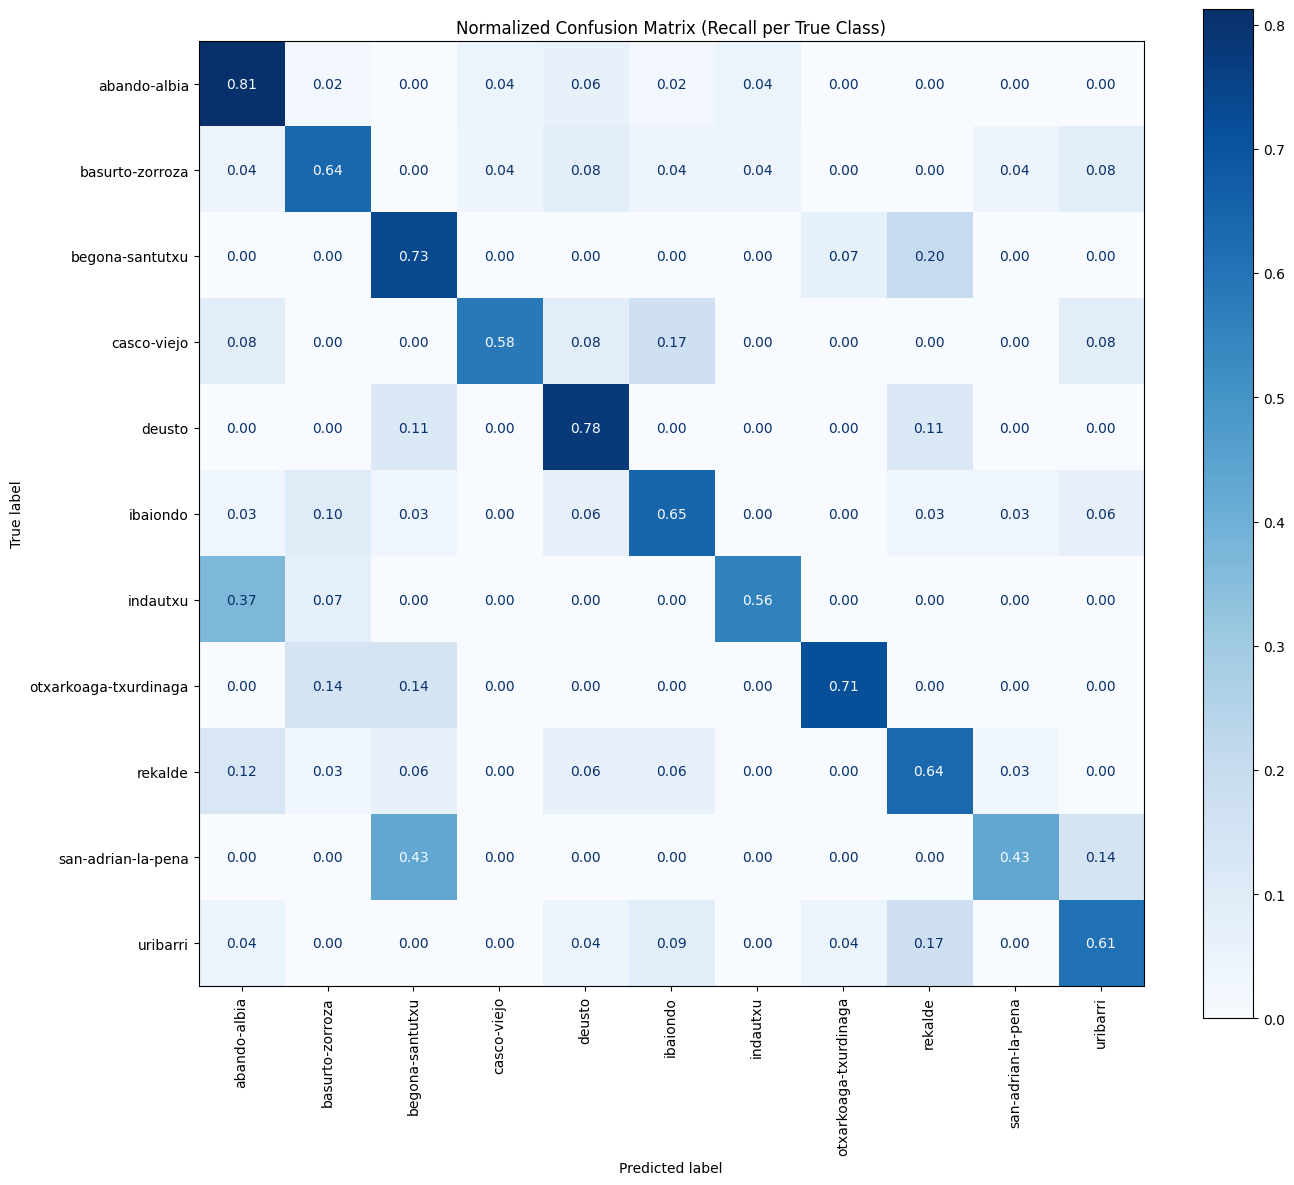

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

# Temporary encoder for original text zone labels
le_temp = LabelEncoder()
le_temp.fit(y_zone)
class_names = le_temp.classes_

print("Detected zone categories:")
print(class_names)

# Retrieve best Optuna params
best_params = study.best_params
# Add fixed params
best_params['random_state'] = 42
best_params['class_weight'] = 'balanced'
best_params['objective'] = 'multiclass'
best_params['n_jobs'] = -1


# Train initial final model
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train_raw, y_train_raw)

# Predict
y_pred = final_model.predict(X_test_raw)

# Classification report
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test_raw, y_pred, target_names=class_names))
# Confusion matrix (normalized)
print("\n--- Normalized Confusion Matrix ---")
fig, ax = plt.subplots(figsize=(14, 12))
ConfusionMatrixDisplay.from_predictions(
    y_test_raw, y_pred,
    ax=ax,
    display_labels=class_names,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Normalized Confusion Matrix (Recall per True Class)")
plt.tight_layout()
plt.show()

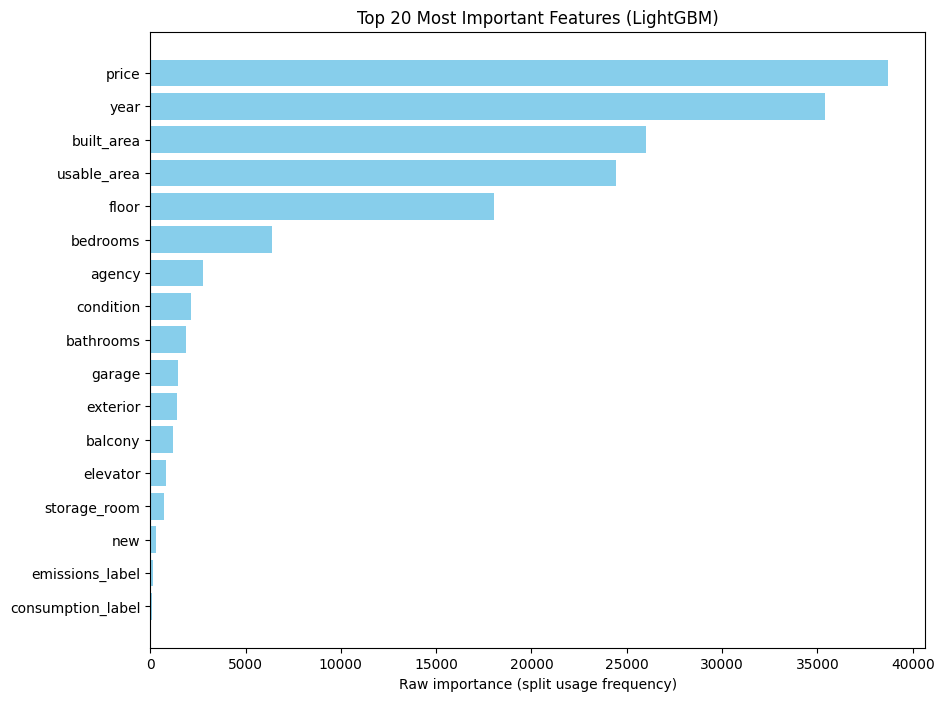

In [68]:
# Extract importances from initial final model
importances = final_model.feature_importances_
feature_names = X_train_raw.columns

# Build DataFrame and select top 20
df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
df_imp = df_imp.sort_values(by='importance', ascending=False).head(20)

# Plot top features
plt.figure(figsize=(10, 8))
plt.barh(df_imp['feature'], df_imp['importance'], color='skyblue')
plt.xlabel("Raw importance (split usage frequency)")
plt.gca().invert_yaxis()
plt.title("Top 20 Most Important Features (LightGBM)")
plt.show()

### 14. Feature Engineering: Add price_per_m2

Variable price_m2 created in Train and Test.
Training model with price_m2 feature...

--- Classification Report (with price_m2) ---
                       precision    recall  f1-score   support

         abando-albia       0.68      0.79      0.73        48
      basurto-zorroza       0.57      0.52      0.54        25
      begona-santutxu       0.56      0.67      0.61        15
          casco-viejo       0.86      0.50      0.63        12
               deusto       0.68      0.83      0.75        18
             ibaiondo       0.68      0.68      0.68        31
             indautxu       0.73      0.59      0.65        27
otxarkoaga-txurdinaga       0.71      0.71      0.71         7
              rekalde       0.64      0.64      0.64        33
   san-adrian-la-pena       0.50      0.43      0.46         7
             uribarri       0.71      0.65      0.68        23

             accuracy                           0.66       246
            macro avg       0.66      0.64     

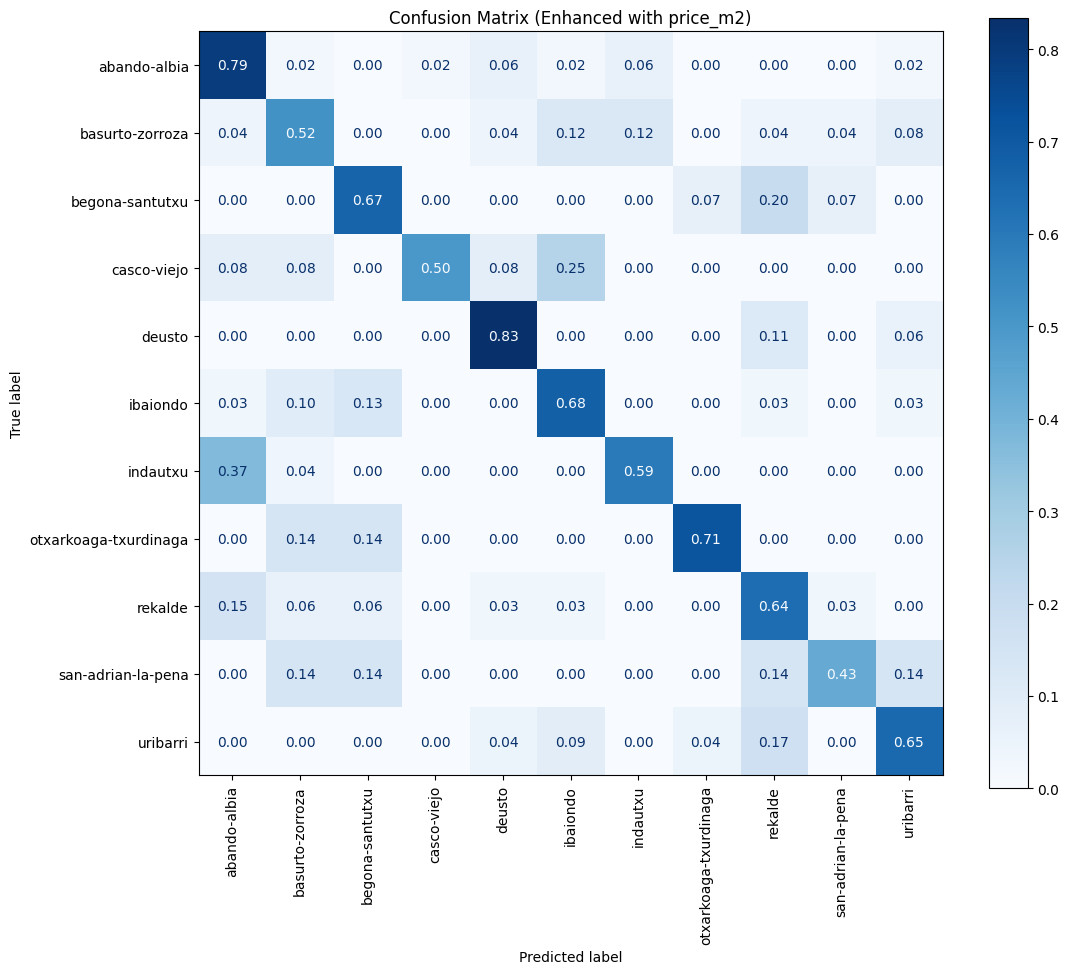

In [69]:
# 1. Apply Feature Engineering to the ORIGINAL DataFrames
X_train_raw['price_m2'] = X_train_raw['price'] / X_train_raw['usable_area']
X_test_raw['price_m2'] = X_test_raw['price'] / X_test_raw['usable_area'] # Vital for the final predict!

# Update the copy for Optuna
X_zone_unencoded_1 = X_train_raw.copy()

print(f"Variable price_m2 created in Train and Test.")


# Re-train with previously found best parameters (before new Optuna run)
final_model_m2 = LGBMClassifier(**best_params)
print("Training model with price_m2 feature...")
final_model_m2.fit(X_train_raw, y_train_raw)

y_pred_m2 = final_model_m2.predict(X_test_raw)

print("\n--- Classification Report (with price_m2) ---")
print(classification_report(y_test_raw, y_pred_m2, target_names=class_names))

# Feature importance (top 10)
importances = final_model_m2.feature_importances_
df_imp = pd.DataFrame({'Feature': X_train_raw.columns, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(10)
print("\n--- Top 10 Features (with price_m2) ---")
print(df_imp)

# Normalized confusion matrix for comparison
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test_raw, y_pred_m2,
    ax=ax,
    display_labels=class_names,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Confusion Matrix (Enhanced with price_m2)")
plt.show()

### 15. Optuna Re-Optimization Including price_per_m2

In [70]:
# Re-optimize after adding price_m2

def objective(trial):
    param = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'class_weight': 'balanced',
        'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 5.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 5.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'subsample_freq': 1
    }
    model = LGBMClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_zone_unencoded_1, y_zone_unencoded_1, cv=cv, scoring='f1_macro', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
print("Re-optimizing with engineered feature price_m2 (50 trials)...")
study.optimize(objective, n_trials=50)

print(f"Final Best Macro F1 with price_m2: {study.best_value:.4f}")

[I 2025-11-29 14:44:22,104] A new study created in memory with name: no-name-fdea6c97-8b0a-47a7-aad3-be647d80a056


Re-optimizing with engineered feature price_m2 (50 trials)...


[I 2025-11-29 14:44:32,194] Trial 0 finished with value: 0.5678165484387981 and parameters: {'n_estimators': 275, 'learning_rate': 0.0200846209458707, 'num_leaves': 33, 'max_depth': 15, 'min_child_samples': 17, 'reg_alpha': 0.0020162598445824737, 'reg_lambda': 0.3676649799436279, 'colsample_bytree': 0.6213123563949562, 'subsample': 0.6469320681294645}. Best is trial 0 with value: 0.5678165484387981.
[I 2025-11-29 14:44:41,712] Trial 1 finished with value: 0.5665304296020854 and parameters: {'n_estimators': 674, 'learning_rate': 0.043747636732991264, 'num_leaves': 33, 'max_depth': 10, 'min_child_samples': 9, 'reg_alpha': 2.9340233711674935, 'reg_lambda': 0.06944785759588729, 'colsample_bytree': 0.6711810710078246, 'subsample': 0.6916357962123081}. Best is trial 0 with value: 0.5678165484387981.
[I 2025-11-29 14:44:41,712] Trial 1 finished with value: 0.5665304296020854 and parameters: {'n_estimators': 674, 'learning_rate': 0.043747636732991264, 'num_leaves': 33, 'max_depth': 10, 'min_ch

Final Best Macro F1 with price_m2: 0.6126


In [71]:
# Visualization of optimization trajectory & parameter importance
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

### 16. Feature Importance (Final Model)

Training champion LightGBM model...

--- Final Classification Report ---
                       precision    recall  f1-score   support

         abando-albia       0.75      0.79      0.77        48
      basurto-zorroza       0.70      0.64      0.67        25
      begona-santutxu       0.58      0.73      0.65        15
          casco-viejo       0.88      0.58      0.70        12
               deusto       0.58      0.83      0.68        18
             ibaiondo       0.68      0.68      0.68        31
             indautxu       0.86      0.70      0.78        27
otxarkoaga-txurdinaga       0.86      0.86      0.86         7
              rekalde       0.67      0.61      0.63        33
   san-adrian-la-pena       0.50      0.43      0.46         7
             uribarri       0.70      0.70      0.70        23

             accuracy                           0.70       246
            macro avg       0.70      0.69      0.69       246
         weighted avg       0.71      0.70 

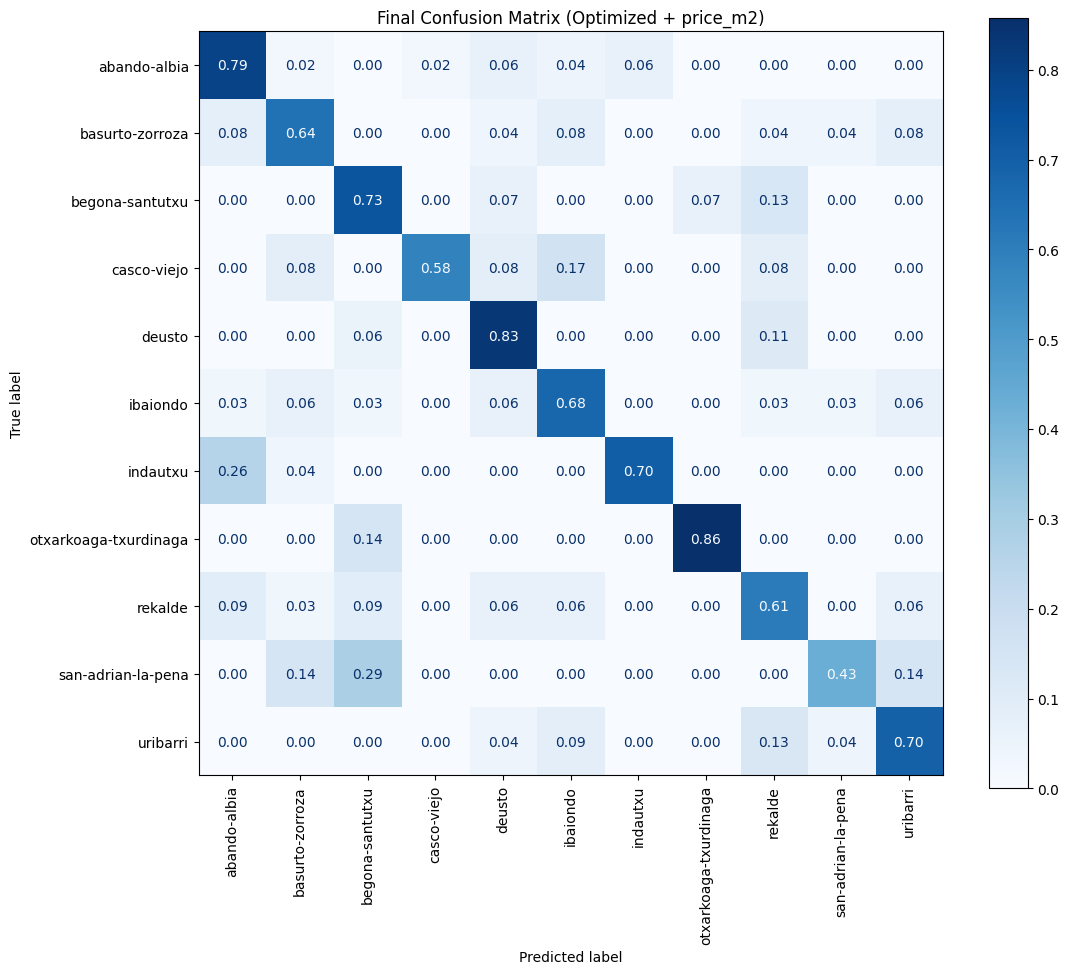

C:\Users\iker\AppData\Local\Temp\ipykernel_25072\2691160080.py:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




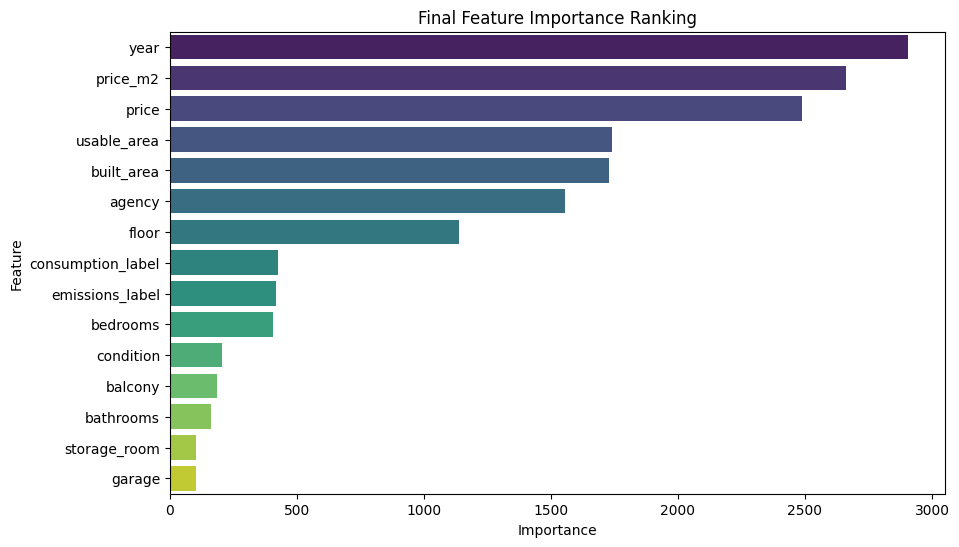

In [ ]:
# Best model parameters from latest Optuna run
best_params = study.best_params

# Add fixed parameters
best_params['random_state'] = 42
best_params['class_weight'] = 'balanced'
best_params['objective'] = 'multiclass'
best_params['n_jobs'] = -1
best_params['verbose'] = -1

print("Training champion LightGBM model...")
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train_raw, y_train_raw)
y_pred = final_model.predict(X_test_raw)

print("\n--- Final Classification Report ---")
print(classification_report(y_test_raw, y_pred, target_names=class_names))
print("\n--- Final Normalized Confusion Matrix ---")
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test_raw, y_pred,
    ax=ax,
    display_labels=class_names,
    xticks_rotation='vertical',
    cmap='Blues',
    normalize='true',
    values_format=".2f"
)
plt.title("Final Confusion Matrix (Optimized + price_m2)")
plt.show()

# Feature importance ranking
importances = final_model.feature_importances_
df_imp = pd.DataFrame({'Feature': X_train_raw.columns, 'Importance': importances})
df_imp = df_imp.sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_imp, x='Importance', y='Feature', palette='viridis')
plt.title('Final Feature Importance Ranking')
plt.show()

## 17. Interpretation

### ALE

In [ ]:
# Select a subset of features to visualize ALE in a readable way
# Use model importances to select
num_cols = list(X_train_raw.select_dtypes(include=[np.number]).columns)
importances = final_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': X_train_raw.columns, 'importance': importances})
feat_imp_df = feat_imp_df[feat_imp_df['feature'].isin(num_cols)]

# Top 4 most important numeric features
top_features = feat_imp_df.sort_values('importance', ascending=False)['feature'].head(4).tolist()
print('Top features for ALE:', top_features)

Top features for ALE: ['year', 'price_m2', 'price', 'usable_area']


In [ ]:
# 1. Identify columns
categorical_cols = X_train_raw.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()
numeric_cols = X_train_raw.select_dtypes(include=['number']).columns.tolist()
all_cols = X_train_raw.columns.tolist()

# 2. Save the EXACT data types from training
train_dtypes = X_train_raw.dtypes.to_dict()

# 3. Train the Encoder
encoder = OrdinalEncoder()
# Convert to string to avoid issues with nulls/mixed types
X_train_str = X_train_raw.copy()
for col in categorical_cols:
    X_train_str[col] = X_train_str[col].astype(str)
    
encoder.fit(X_train_str[categorical_cols])

# 4. Prepare numeric data for ALE
X_train_num = X_train_raw.copy()
X_train_num[categorical_cols] = encoder.transform(X_train_str[categorical_cols])
X_train_numpy = X_train_num.values

# 5. DEFINE THE CORRECTED WRAPPER
def predictor_wrapper(X_ndarray):
    # A. Reconstruct basic DataFrame
    df_temp = pd.DataFrame(X_ndarray, columns=all_cols)
    
    # B. Ensure numeric columns are float
    for col in numeric_cols:
        df_temp[col] = df_temp[col].astype(float)

    # C. Decode categoricals
    if len(categorical_cols) > 0:
        # Round and clip to avoid invalid indices generated by ALE
        cat_data = df_temp[categorical_cols].values.round().astype(int)
        for i, col in enumerate(categorical_cols):
            max_val = len(encoder.categories_[i]) - 1
            cat_data[:, i] = np.clip(cat_data[:, i], 0, max_val)
            
        # Convert back to text
        decoded_data = encoder.inverse_transform(cat_data)
        
        # D. ASSIGN THE EXACT TYPES FROM TRAINING
        for i, col in enumerate(categorical_cols):
            # First assign the values
            df_temp[col] = decoded_data[:, i]
            # Then force the original data type (which contains the complete list of categories)
            df_temp[col] = df_temp[col].astype(train_dtypes[col])

    # E. Predict
    return final_model.predict_proba(df_temp)

# 6. Initialize and Execute ALE
print("Initializing ALE with type correction...")
ale_explainer = ALE(predictor_wrapper, feature_names=all_cols, target_names=class_names)

print("Calculating explanations (patience)...")
final_model_exp = ale_explainer.explain(X_train_numpy)

print("Success! Plots ready.")

Initializing ALE with type correction...
Calculating explanations (patience)...
Success! Plots ready.
Success! Plots ready.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def comparar_barrios(feature, barrio1, barrio2, explanation_object, color1='blue', color2='orange'):
    """
    Grafica curvas ALE para dos barrios ignorando la línea horizontal de referencia.
    """
    try:
        idx1 = list(class_names).index(barrio1)
        idx2 = list(class_names).index(barrio2)
        
        print(f"Comparando {feature}: {barrio1} vs {barrio2}")
        
        fig, ax = plt.subplots(figsize=(8, 5))
        
        # We plot
        plot_ale(explanation_object, 
                 features=[feature], 
                 targets=[idx1, idx2],
                 n_cols=1, 
                 sharey=True,
                 ax=ax)

        # Get all the lines drawn
        lines = ax.get_lines()
        
        # Filter: We only want the lines that are NOT the flat line at 0
        # The logic is: if the maximum absolute Y value is almost 0, it's the reference line.
        data_lines = [line for line in lines if np.max(np.abs(line.get_ydata())) > 0.0001]

        # Now we color only the found data lines
        colores_a_usar = [color1, color2]
        
        for i, line in enumerate(data_lines):
            if i < len(colores_a_usar): # Avoid errors if there are more lines than expected
                line.set_color(colores_a_usar[i])
                line.set_linewidth(2.5) 
                line.set_alpha(0.8)
                
        for line in lines:
            if line not in data_lines:
                line.set_color('gray')
                line.set_linestyle('--')
                line.set_alpha(0.5)

        plt.title(f"Effect of '{feature}' on probability")
        # We manually force the legend to ensure the colors match the names
        from matplotlib.lines import Line2D
        custom_lines = [Line2D([0], [0], color=color1, lw=2.5),
                        Line2D([0], [0], color=color2, lw=2.5)]
        plt.legend(custom_lines, [barrio1, barrio2], loc='best')
        
        plt.grid(True, alpha=0.3)
        plt.show()
        
    except ValueError as e:
        print(f"Error: No se encontró el barrio. Revisa los nombres: {e}")
    except Exception as e:
        print(f"Error inesperado: {e}")

Comparando price_m2: abando-albia vs otxarkoaga-txurdinaga


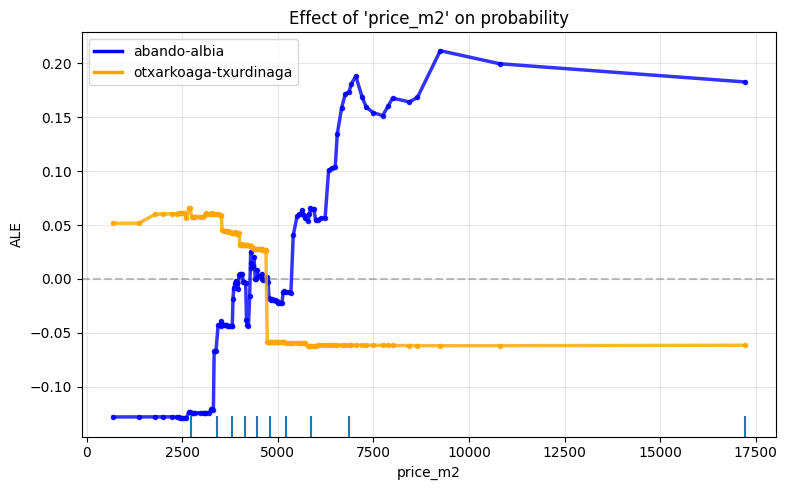

Comparando price_m2: indautxu vs abando-albia


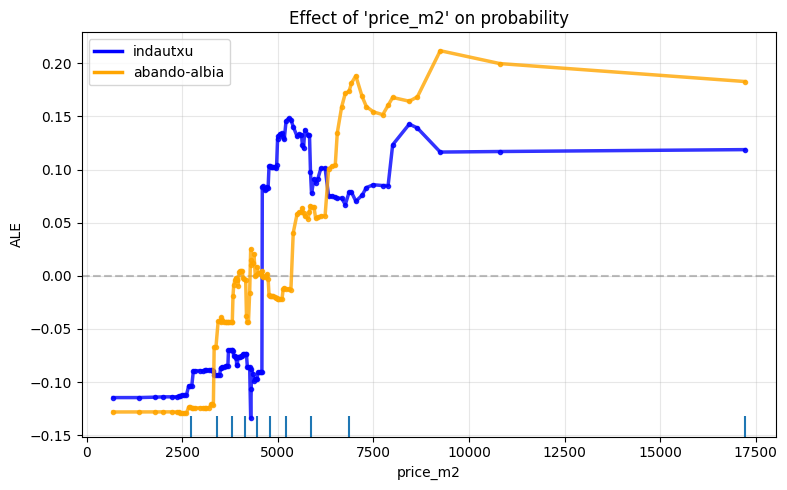

In [ ]:
# A. EXTREME CONTRAST (To validate that the model makes sense)
# Abando (Most expensive zone) vs Otxarkoaga (Most affordable zone)
comparar_barrios('price_m2', 'abando-albia', 'otxarkoaga-txurdinaga', final_model_exp)

# B. SIMILAR (Indautxu vs Abando)
# Both lines rise together because both are expensive zones.
comparar_barrios('price_m2', 'indautxu', 'abando-albia', final_model_exp)

Comparando year: casco-viejo vs abando-albia


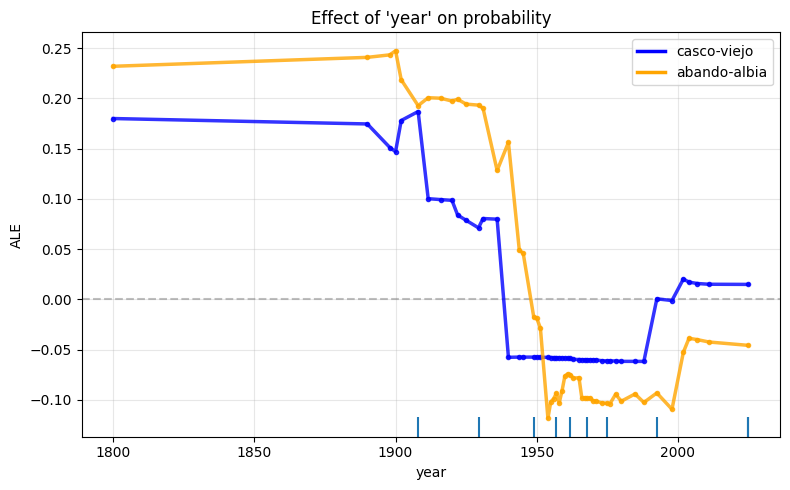

Comparando year: abando-albia vs rekalde


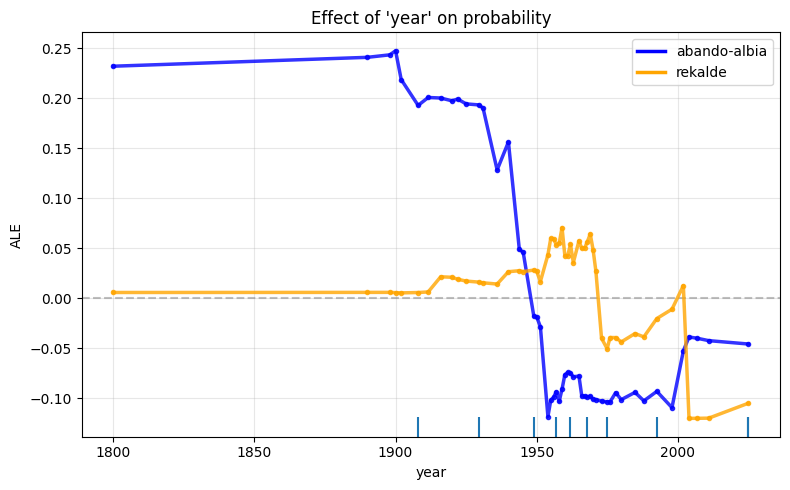

In [109]:
# A. SIMILAR (Casco Viejo vs Abando Albia)
# Casco Viejo (19th century) vs Abando Albia (Old area)
# Year has a similar effect on both cases
comparar_barrios('year', 'casco-viejo', 'abando-albia', final_model_exp)

# B. DIFFERENCE (abando-albia vs rekalde)
comparar_barrios('year', 'abando-albia', 'rekalde', final_model_exp)

Comparando usable_area: abando-albia vs otxarkoaga-txurdinaga


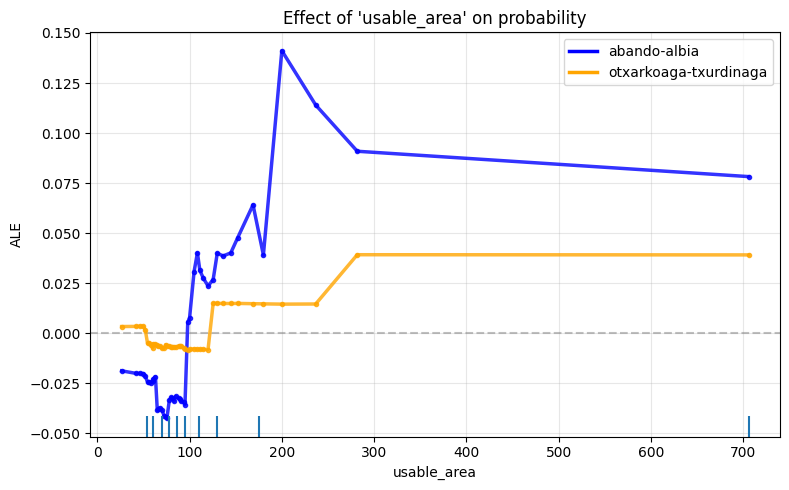

Comparando usable_area: san-adrian-la-pena vs begona-santutxu


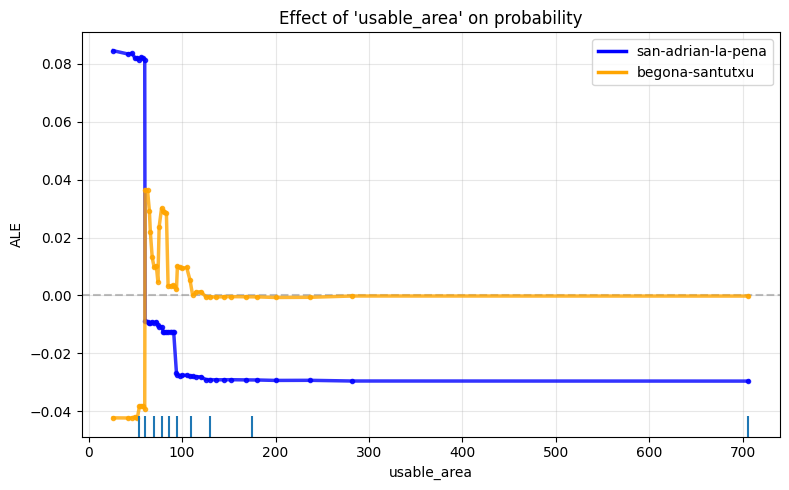

In [110]:
# A. THE CONTRAST (Abando Albia vs Otxarkoaga)
# Abando Albia usually has large apartments (>100m²), Otxarkoaga standard (60-80m²).
comparar_barrios('usable_area', 'abando-albia', 'otxarkoaga-txurdinaga', final_model_exp)
# We should only look at the left side because it is were the data is.

# B. THE DIFFERENCE (San Adrian vs Begona-Santutxu)
comparar_barrios('usable_area', 'san-adrian-la-pena', 'begona-santutxu', final_model_exp)

Comparando floor: casco-viejo vs basurto-zorroza


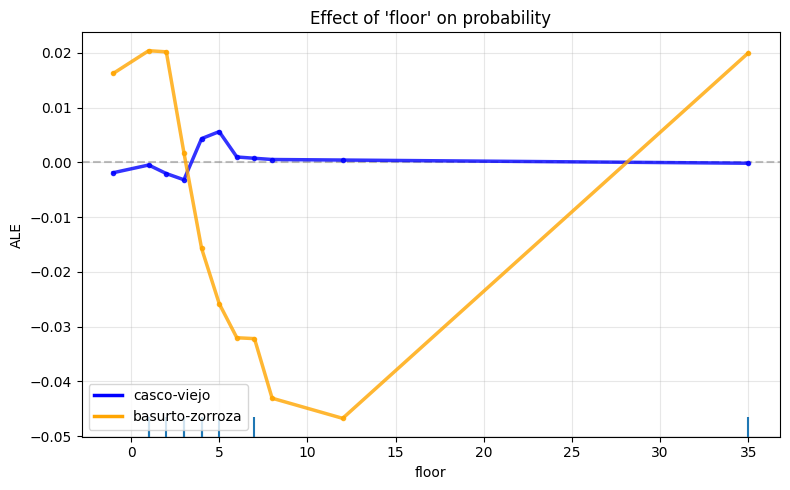

Comparando floor: basurto-zorroza vs rekalde


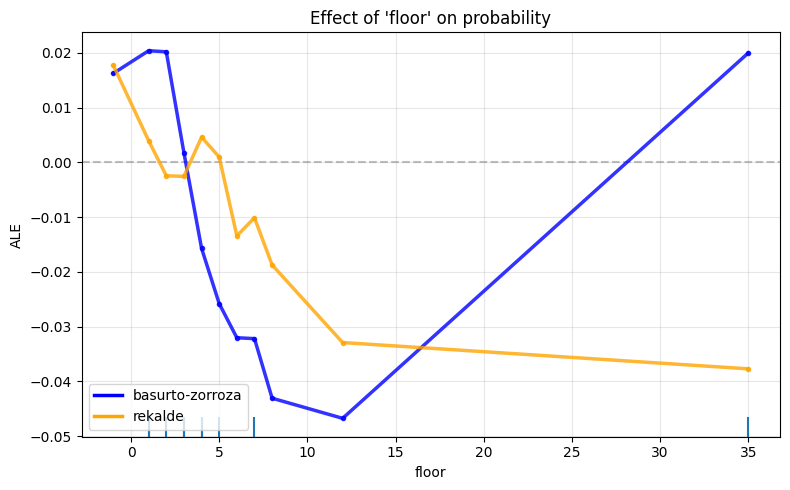

In [111]:
# A. THE CONTRAST (Casco Viejo vs Basurto-Zorroza)
# Casco Viejo rarely exceeds 5 floors. Basurto-Zorroza has more towers.
comparar_barrios('floor', 'casco-viejo', 'basurto-zorroza', final_model_exp)

# B. THE CONFUSION (Basurto vs Rekalde)
# They get confused a bit as they have similar building heights
comparar_barrios('floor', 'basurto-zorroza', 'rekalde', final_model_exp)

### SHAP Values

In [112]:
# Code for SHAP Values
# Create the explainer with the LightGBM model
explainer = shap.TreeExplainer(final_model)

# Calculate SHAP values on the test set (Explanation)
shap_values = explainer(X_test_raw)

--- SHAP ANALYSIS: ABANDO-ALBIA ---


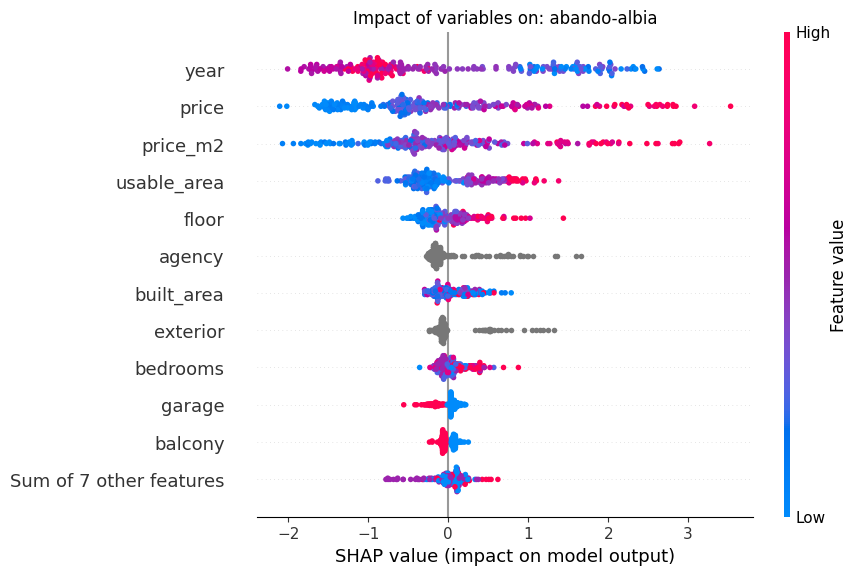


--- SHAP ANALYSIS: OTXARKOAGA-TXURDINAGA ---


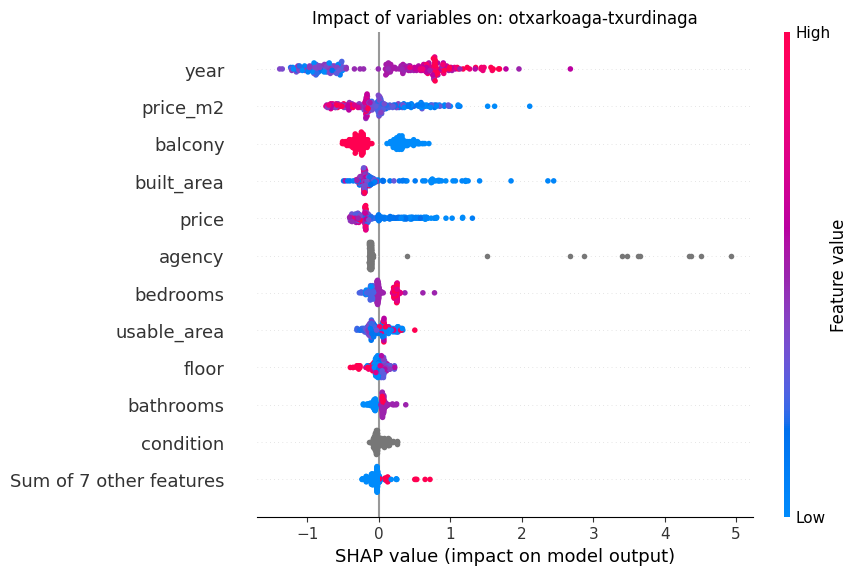

In [ ]:
# USE THIS CELL TO COMPARE TWO CLASSES DIRECTLY

# 1. Choose the two classes you want to compare
clase_A = 'abando-albia'             # E.g.: The most expensive zone
clase_B = 'otxarkoaga-txurdinaga'    # E.g.: The cheapest zone

# 2. Get the indices of those classes
idx_A = list(class_names).index(clase_A)
idx_B = list(class_names).index(clase_B)

# --- PLOT 1: CLASS A ---
print(f"--- SHAP ANALYSIS: {clase_A.upper()} ---")
# show=False allows adding title before showing it
shap.plots.beeswarm(shap_values[:, :, idx_A], max_display=12, show=False)
plt.title(f"Impact of variables on: {clase_A}")
plt.show() # Forces this plot to render before moving to the next one

# --- PLOT 2: CLASS B ---
print(f"\n--- SHAP ANALYSIS: {clase_B.upper()} ---")
shap.plots.beeswarm(shap_values[:, :, idx_B], max_display=12, show=False)
plt.title(f"Impact of variables on: {clase_B}")
plt.show()


# THEY ARE ALMOS OPPOSITES


--- WATERFALL: ABANDO-ALBIA (House index 1) ---


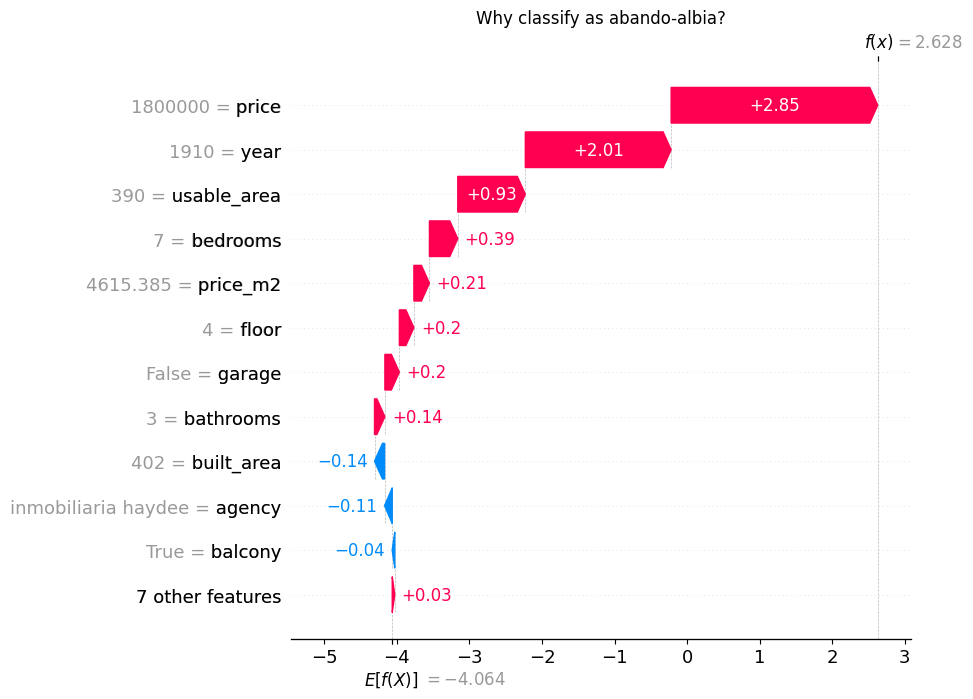


--- WATERFALL: OTXARKOAGA-TXURDINAGA (House index 6) ---


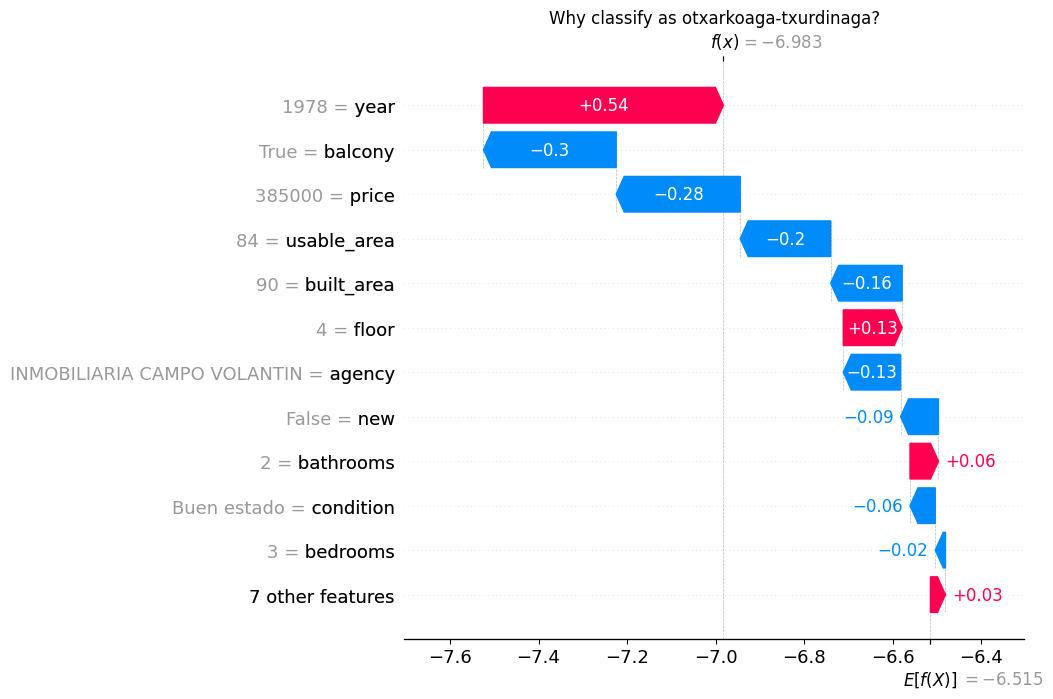

In [ ]:
# USE THIS CELL TO COMPARE TWO INSTANCES OF TWO CLASSES DIRECTLY

# 1. Choose the classes to compare
zona_A = 'abando-albia'
zona_B = 'otxarkoaga-txurdinaga'

targets = [zona_A, zona_B]

for nombre_zona in targets:

    try:
        class_idx = list(class_names).index(nombre_zona)
    except ValueError:
        print(f"Error: The zone '{nombre_zona}' is not in the class_names list.")
        continue

    y_test_values = y_test_raw.values if hasattr(y_test_raw, "values") else y_test_raw
    indices_candidatos = np.where(y_test_values == nombre_zona)[0]
    
    if len(indices_candidatos) > 0:
        # Take first available example
        sample_idx = indices_candidatos[0] 
        
        print(f"\n--- WATERFALL: {nombre_zona.upper()} (House index {sample_idx}) ---")
        
        # 3. Plot
        # Use sample_idx for the house, and class_idx for that class's "opinion"
        shap.plots.waterfall(
            shap_values[sample_idx, :, class_idx], 
            max_display=12, 
            show=False
        )
        plt.title(f"Why classify as {nombre_zona}?")
        plt.show()
        
    else:
        print(f"No examples of '{nombre_zona}' in the Test set.")